In [2]:
import pandas as pd

In [3]:
bike_rentals = pd.read_csv('bike_rental_hour.csv')

In [4]:
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [5]:
## In this exercise, I am going to try to predict the total
##    number of bike rentals in a given hour using all the other
## columns except for casual and registered

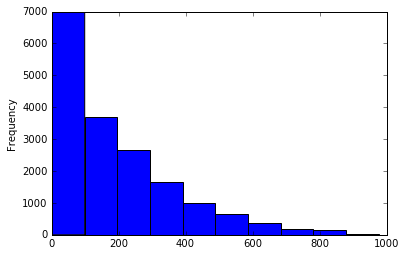

In [10]:
%matplotlib inline
bike_rentals['cnt'].plot(kind='hist')

In [12]:
bike_rentals.corr()['cnt']

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

In [16]:
def assign_label(val):
    
    if val >=6 and val <12:
        return 1
    if val >=12 and val <18:
        return 2
    if val >=18:
        return 3
    if val >=0 and val <6:
        return 4

In [17]:
bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)

In [18]:
bike_rentals['time_label'].value_counts()

2    4375
3    4368
1    4360
4    4276
Name: time_label, dtype: int64


## Error metric
The mean squared error metric makes the most sense to evaluate our error. MSE works on continuous numeric data, which fits our data quite well.

In [117]:
train = bike_rentals.sample(frac = .8)

In [118]:
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

In [119]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [120]:
pred_cols = train.columns.tolist()

In [121]:
pred_cols

['instant',
 'dteday',
 'season',
 'yr',
 'mnth',
 'hr',
 'holiday',
 'weekday',
 'workingday',
 'weathersit',
 'temp',
 'atemp',
 'hum',
 'windspeed',
 'casual',
 'registered',
 'cnt',
 'time_label']

In [122]:
pred_cols.remove('cnt')
pred_cols.remove('registered')
pred_cols.remove('dteday')
pred_cols.remove('casual')




In [123]:
LR = LinearRegression()

In [124]:
LR.fit(train[pred_cols],train['cnt'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [125]:
test_predictions = LR.predict(test[pred_cols])

In [126]:
error = mean_squared_error(test['cnt'],test_predictions)

error

16767.662111320857

The MSE penalizes larger errors, and the data has some outliers. So it might inflate the numbers. 

In [127]:
from sklearn.tree import DecisionTreeRegressor

In [177]:
errors = []
for i in range(1,30,1):    
    dt = DecisionTreeRegressor(min_samples_leaf=3,
                              max_depth = i
                              )

    dt.fit(train[pred_cols],train['cnt'])

    predictions = dt.predict(test[pred_cols])

    error = mean_squared_error(test['cnt'],predictions)
    print("Min_leaves: %s"%i, error,i/2)
    errors.append([i,error,i/2])

Min_leaves: 1 21961.124580064323 0.5
Min_leaves: 2 18243.96722083979 1.0
Min_leaves: 3 15479.525431793818 1.5
Min_leaves: 4 13343.390586704449 2.0
Min_leaves: 5 11390.124588242254 2.5
Min_leaves: 6 10461.444032114321 3.0
Min_leaves: 7 6862.054872587799 3.5
Min_leaves: 8 5113.60940159345 4.0
Min_leaves: 9 4227.055496172929 4.5
Min_leaves: 10 3486.436113392184 5.0
Min_leaves: 11 3106.476904986374 5.5
Min_leaves: 12 2862.181210164087 6.0
Min_leaves: 13 2687.9529999617585 6.5
Min_leaves: 14 2667.8366108496625 7.0
Min_leaves: 15 2638.3150714790722 7.5
Min_leaves: 16 2605.7747256908424 8.0
Min_leaves: 17 2558.9998409204513 8.5
Min_leaves: 18 2622.0869531198987 9.0
Min_leaves: 19 2610.076156634639 9.5
Min_leaves: 20 2561.739019690358 10.0
Min_leaves: 21 2639.6696154028145 10.5
Min_leaves: 22 2584.511264957277 11.0
Min_leaves: 23 2561.0246185582096 11.5
Min_leaves: 24 2591.539598912701 12.0
Min_leaves: 25 2596.970046385036 12.5
Min_leaves: 26 2614.75635412671 13.0
Min_leaves: 27 2601.169789029

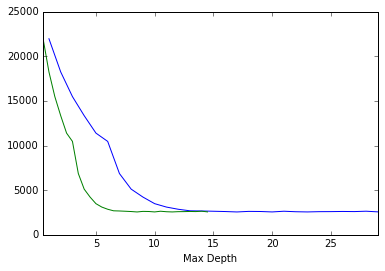

In [178]:
pd.DataFrame(errors,columns=['Leaves','Error','Max Depth']).set_index('Leaves')['Error'].plot()
pd.DataFrame(errors,columns=['Leaves','Error','Max Depth']).set_index('Max Depth')['Error'].plot()

In [176]:
for i in range(1,10,): 
    print(i)

1
2
3
4
5
6
7
8
9


The most accurate min_samples_leaf is 3, while for max_depth the error eventually caps out after 17. The minimum samples per leaf will keep us from making overly-specific rules, while the max_depth will make sure we generalize. This two together created the tree with the least error. 

In [182]:
from sklearn.ensemble import RandomForestRegressor


In [187]:
errors = []
for i in range(14,30,1):    
    dt = RandomForestRegressor(
        min_samples_leaf=1,                           
                              #max_depth = i
                              )

    dt.fit(train[pred_cols],train['cnt'])

    predictions = dt.predict(test[pred_cols])

    error = mean_squared_error(test['cnt'],predictions)
    print("Min_leaves: %s"%i, error,i/2)
    errors.append([i,error,i/2])

Min_leaves: 14 1875.5757681242806 7.0
Min_leaves: 15 1818.324439010357 7.5
Min_leaves: 16 1754.7266110471805 8.0
Min_leaves: 17 1765.907356156502 8.5
Min_leaves: 18 1821.8991743383197 9.0
Min_leaves: 19 1830.3859608745686 9.5
Min_leaves: 20 1806.3380983889524 10.0
Min_leaves: 21 1793.4606300345226 10.5
Min_leaves: 22 1847.039346950518 11.0
Min_leaves: 23 1783.9963837744533 11.5
Min_leaves: 24 1761.6591168009206 12.0
Min_leaves: 25 1838.3176093210589 12.5
Min_leaves: 26 1672.1006501726124 13.0
Min_leaves: 27 1801.7881012658227 13.5
Min_leaves: 28 1876.629743958573 14.0
Min_leaves: 29 1899.8365650172607 14.5


Min_leaves: 17 1763.0013335537635 8.5

In [189]:
errors = []
for i in range(14,30,1):    
    dt = RandomForestRegressor(
        min_samples_leaf=1,                           
                              #max_depth = i
                              )

    dt.fit(train[pred_cols],train['casual'])

    predictions = dt.predict(test[pred_cols])

    error = mean_squared_error(test['casual'],predictions)
    print("Min_leaves: %s"%i, error,i/2)
    errors.append([i,error,i/2])

Min_leaves: 14 217.42638377445337 7.0
Min_leaves: 15 223.84952531645567 7.5
Min_leaves: 16 219.4078768699655 8.0
Min_leaves: 17 217.29623993095512 8.5
Min_leaves: 18 216.5912571921749 9.0
Min_leaves: 19 212.69565304948216 9.5
Min_leaves: 20 199.2767577675489 10.0
Min_leaves: 21 203.7811248561565 10.5
Min_leaves: 22 216.16178941311853 11.0
Min_leaves: 23 213.6008170310702 11.5
Min_leaves: 24 219.68422612197932 12.0
Min_leaves: 25 209.8753768699655 12.5
Min_leaves: 26 209.58454257767545 13.0
Min_leaves: 27 216.22285673187574 13.5
Min_leaves: 28 216.24886363636364 14.0
Min_leaves: 29 218.66119102416573 14.5


In [190]:
errors = []
for i in range(14,30,1):    
    dt = RandomForestRegressor(
        min_samples_leaf=1,                           
                              #max_depth = i
                              )

    dt.fit(train[pred_cols],train['registered'])

    predictions = dt.predict(test[pred_cols])

    error = mean_squared_error(test['registered'],predictions)
    print("Min_leaves: %s"%i, error,i/2)
    errors.append([i,error,i/2])

Min_leaves: 14 1241.8725258918298 7.0
Min_leaves: 15 1307.8038952819331 7.5
Min_leaves: 16 1292.207819332566 8.0
Min_leaves: 17 1305.3754459148447 8.5
Min_leaves: 18 1327.3532393555809 9.0
Min_leaves: 19 1251.469522439586 9.5
Min_leaves: 20 1373.2706214039124 10.0
Min_leaves: 21 1317.2636766398157 10.5
Min_leaves: 22 1194.5005523590335 11.0
Min_leaves: 23 1231.5758429229002 11.5
Min_leaves: 24 1304.0817232451095 12.0
Min_leaves: 25 1270.5270598388952 12.5
Min_leaves: 26 1230.9035356731874 13.0
Min_leaves: 27 1259.777574798619 13.5
Min_leaves: 28 1272.4090420023015 14.0
Min_leaves: 29 1363.3913003452244 14.5
